In [1]:
# ============================================================
#  BIKE SHARING
# ============================================================

import torch
from strel import *

torch.manual_seed(42)

# -------------------------------
# 1. Scenario simulato
# -------------------------------
B, N, F, T = 1, 5, 4, 6  # batch, stazioni, features, time

# Coordinate statiche (rete 2x2 + centro)
coords = torch.tensor([
    [0.0, 0.0],   # S1
    [1.0, 0.0],   # S2
    [0.0, 1.0],   # S3
    [1.0, 1.0],   # S4
    [0.5, 0.5]    # S5 (centrale)
])
vel = torch.zeros_like(coords)
x = torch.cat([coords, vel], dim=1).unsqueeze(0).unsqueeze(-1).repeat(1, 1, 1, T)

# Numero di biciclette per stazione (variazione nel tempo)
bikes = torch.tensor([
    [2, 3, 4, 5, 6, 6],  # S1 - crescita regolare
    [5, 4, 3, 2, 1, 0],  # S2 - calo drastico
    [1, 2, 3, 4, 5, 5],  # S3 - crescita costante
    [3, 2, 1, 0, 1, 2],  # S4 - fluttuazioni basse
    [6, 6, 5, 4, 3, 2]   # S5 - riserva centrale
], dtype=torch.float32)

signal = bikes.unsqueeze(0).unsqueeze(2)  # [B,N,1,T]

# -------------------------------
# 2. Predicati atomici
# -------------------------------
phi_ge3 = Atom(var_index=0, threshold=3, lte=False)  # bici ≥3
phi_ge5 = Atom(var_index=0, threshold=5, lte=False)  # bici ≥5
phi_eq0 = Atom(var_index=0, threshold=0, lte=True)   # bici =0


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


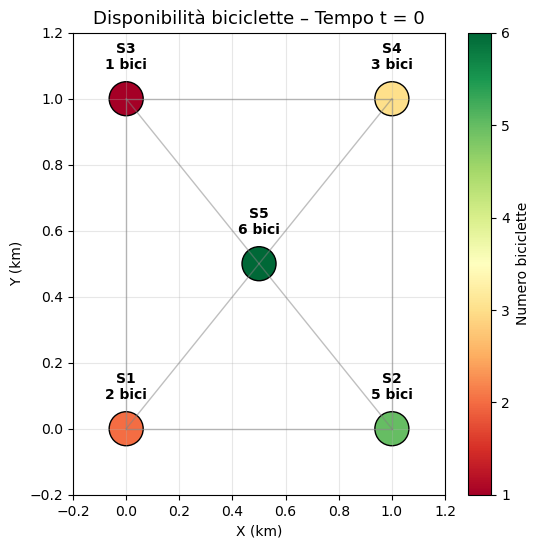

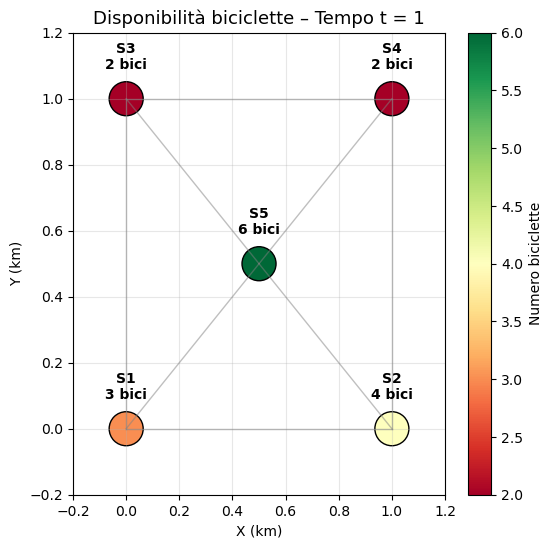

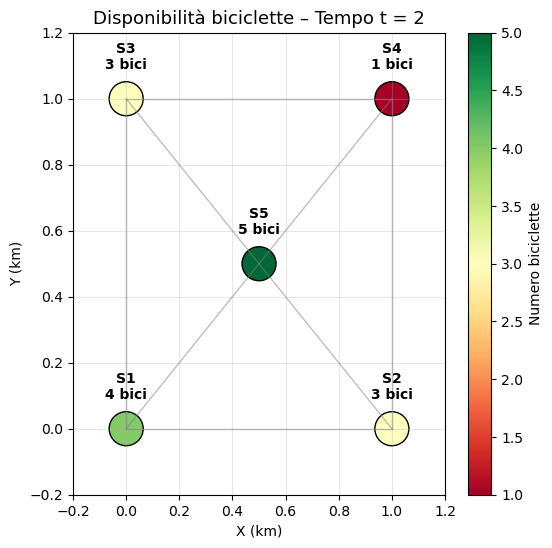

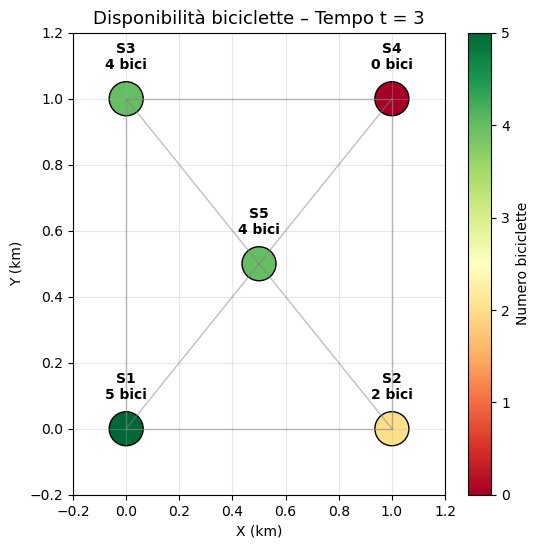

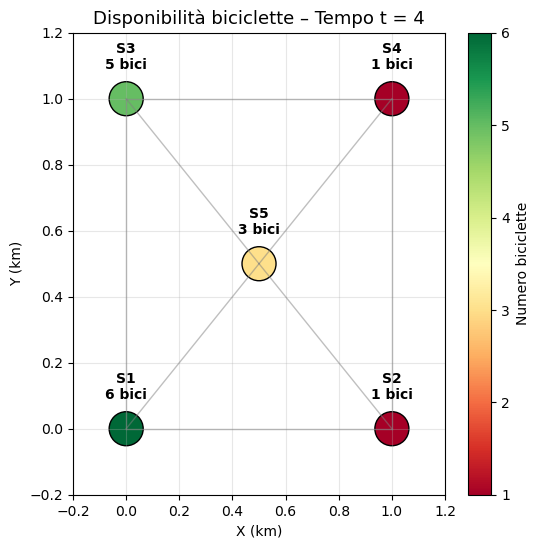

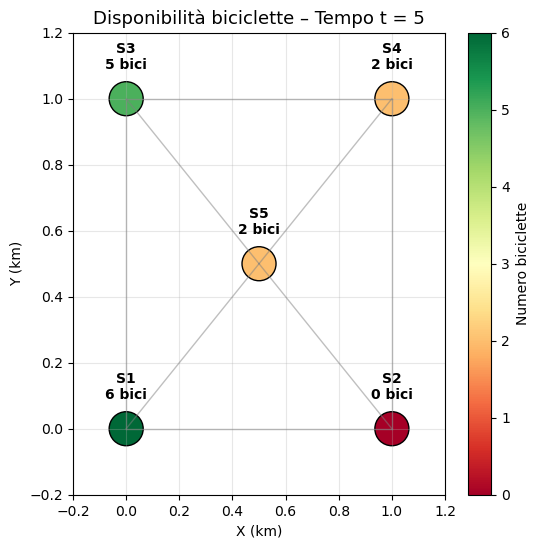

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bike_sharing(coords, bikes, t):
    """
    Visualizza la disposizione spaziale delle stazioni e la disponibilità di bici al tempo t.
    """
    N = coords.shape[0]
    x_coord = coords[:,0].numpy()
    y_coord = coords[:,1].numpy()
    n_bikes = bikes[:,t].numpy()

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(
        x_coord, y_coord, 
        c=n_bikes, cmap='RdYlGn', s=600, edgecolors='k'
    )

    for i, (x_i, y_i, b_i) in enumerate(zip(x_coord, y_coord, n_bikes), 1):
        plt.text(x_i, y_i + 0.08, f"S{i}\n{int(b_i)} bici", 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    # connessioni indicative (rete a griglia + centro)
    edges = [(0,1),(0,2),(1,3),(2,3),(0,4),(1,4),(2,4),(3,4)]
    for (i,j) in edges:
        plt.plot([x_coord[i], x_coord[j]], [y_coord[i], y_coord[j]], 
                 'gray', lw=1, alpha=0.5)

    plt.title(f"Disponibilità biciclette – Tempo t = {t}", fontsize=13)
    plt.xlabel("X (km)")
    plt.ylabel("Y (km)")
    plt.colorbar(scatter, label="Numero biciclette")
    plt.xlim(-0.2,1.2)
    plt.ylim(-0.2,1.2)
    plt.grid(True, alpha=0.3)
    plt.show()

# -------------------------------
# PLOT PER TUTTI I TIMESTEP (T = 6)
# -------------------------------
for t in range(T):
    plot_bike_sharing(coords, bikes, t)


In [3]:
# ============================================================
#  ANALISI TEMPORALE (da t=0 a t=5)
# ============================================================

print("\n============================================================")
print(" A) TEST TEMPORALI – EVOLUZIONE DELLA DISPONIBILITÀ")
print("============================================================")

# 1️⃣ Entro 2 step temporali, la stazione deve avere almeno 5 bici
phi_temp1 = Eventually(phi_ge5, left_time_bound=0, right_time_bound=2)

# 2️⃣ Nei prossimi 2 step, la stazione deve sempre avere almeno 3 bici
phi_temp2 = Globally(phi_ge3, left_time_bound=0, right_time_bound=2)

# 3️⃣ Entro 4 step, ci sarà un momento in cui non ci saranno bici
phi_temp3 = Eventually(phi_eq0, left_time_bound=0, right_time_bound=4)

temporal_tests = {
    "1. Entro 2 step la stazione avrà ≥5 bici" : phi_temp1,
    "2. Nei prossimi 2 step la stazione manterrà ≥3 bici" : phi_temp2,
    "3. Entro 4 step si verificherà assenza di bici" : phi_temp3
}

# Loop su tutte le formule
for name, phi in temporal_tests.items():
    print(f"\n{name}")
    print("Timestep | Stazione | Bool | Robustezza")
    
    # Valutazioni complete nel tempo
    bool_all  = phi._boolean(signal).int()[0,:,0,:]      # [N, T']
    quant_all = phi._quantitative(signal)[0,:,0,:]       # [N, T']
    
    # Allineamento alla lunghezza temporale del segnale originale (T = 6)
    T_signal = signal.shape[-1]
    T_formula = bool_all.shape[-1]
    pad_len = T_signal - T_formula
    if pad_len > 0:
        bool_all  = torch.nn.functional.pad(bool_all,  (0, pad_len),  mode='replicate')
        quant_all = torch.nn.functional.pad(quant_all, (0, pad_len),  mode='replicate')
    
    # Stampa per ogni timestep
    for t in range(T_signal):
        for i in range(bool_all.shape[0]):
            print(f"   t={t:<2}    S{i+1:<2}     {int(bool_all[i,t])}      {float(quant_all[i,t]):.3f}")
    print("------------------------------------------------------------")



 A) TEST TEMPORALI – EVOLUZIONE DELLA DISPONIBILITÀ

1. Entro 2 step la stazione avrà ≥5 bici
Timestep | Stazione | Bool | Robustezza
   t=0     S1      0      -1.000
   t=0     S2      1      0.000
   t=0     S3      0      -2.000
   t=0     S4      0      -2.000
   t=0     S5      1      1.000
   t=1     S1      1      0.000
   t=1     S2      0      -1.000
   t=1     S3      0      -1.000
   t=1     S4      0      -3.000
   t=1     S5      1      1.000
   t=2     S1      1      1.000
   t=2     S2      0      -2.000
   t=2     S3      1      0.000
   t=2     S4      0      -4.000
   t=2     S5      1      0.000
   t=3     S1      1      1.000
   t=3     S2      0      -3.000
   t=3     S3      1      0.000
   t=3     S4      0      -3.000
   t=3     S5      0      -1.000
   t=4     S1      1      1.000
   t=4     S2      0      -3.000
   t=4     S3      1      0.000
   t=4     S4      0      -3.000
   t=4     S5      0      -1.000
   t=5     S1      1      1.000
   t=5     S2      

In [4]:
# ============================================================
#  CHUNK 3 — ANALISI SPAZIALE (per ogni timestep)
# ============================================================

print("\n============================================================")
print(" B) TEST SPAZIALI – DISPONIBILITÀ NELLE VICINANZE")
print("============================================================")

# Per analisi spaziale, unisci coordinate e bici nel tensore
z = torch.cat([x, signal], dim=2)  # [B,N,5,T] → posizioni + bici
phi_ge3 = Atom(var_index=4, threshold=3, lte=False)
phi_ge5 = Atom(var_index=4, threshold=5, lte=False)

# Definizione proprietà spaziali
phi_space1 = Somewhere(phi_ge5, d2=1.0)
phi_space2 = Everywhere(phi_ge3, d2=1.0)
phi_space3 = Surround(left_child=phi_ge3, right_child=phi_ge5, d2=1.0)
phi_space4 = Reach(left_child=phi_ge3, right_child=phi_ge5, d1=0.0, d2=1.5)
phi_space5 = Escape(child=phi_ge3, d1=0.5, d2=1.5)

spatial_tests = {
    "1. Esiste una stazione entro 1 km con ≥5 bici" : phi_space1,
    "2. Tutte le stazioni entro 1 km hanno ≥3 bici" : phi_space2,
    "3. La stazione è circondata (entro 1 km) da stazioni con ≥5 bici" : phi_space3,
    "4. Raggiungibilità (≤1.5 km) di stazioni con ≥5 bici da stazioni con ≥3 bici" : phi_space4,
    "5. Fuga (0.5–1.5 km) verso stazioni con ≥3 bici" : phi_space5
}

# Loop su tutti i timestep
for name, phi in spatial_tests.items():
    print(f"\n{name}")
    print("Timestep | Stazione | Bool | Robustezza")
    bool_all = phi._boolean(z).int()[0,:,0,:]      # [N,T]
    quant_all = phi._quantitative(z)[0,:,0,:]      # [N,T]
    for t in range(T):
        for i in range(N):
            print(f"   t={t:<2}    S{i+1:<2}     {int(bool_all[i,t])}      {float(quant_all[i,t]):.3f}")
    print("------------------------------------------------------------")



 B) TEST SPAZIALI – DISPONIBILITÀ NELLE VICINANZE

1. Esiste una stazione entro 1 km con ≥5 bici
Timestep | Stazione | Bool | Robustezza
   t=0     S1      1      1.000
   t=0     S2      1      1.000
   t=0     S3      1      1.000
   t=0     S4      1      1.000
   t=0     S5      1      1.000
   t=1     S1      1      1.000
   t=1     S2      1      1.000
   t=1     S3      1      1.000
   t=1     S4      1      1.000
   t=1     S5      1      1.000
   t=2     S1      1      0.000
   t=2     S2      1      0.000
   t=2     S3      1      0.000
   t=2     S4      1      0.000
   t=2     S5      1      0.000
   t=3     S1      1      0.000
   t=3     S2      1      0.000
   t=3     S3      1      0.000
   t=3     S4      0      -1.000
   t=3     S5      1      0.000
   t=4     S1      1      1.000
   t=4     S2      1      1.000
   t=4     S3      1      1.000
   t=4     S4      1      0.000
   t=4     S5      1      1.000
   t=5     S1      1      1.000
   t=5     S2      1      1.0

In [6]:
# ============================================================
#  CHUNK 4 — ANALISI SPAZIO-TEMPORALE (da t=0 a t=5)
# ============================================================

print("\n============================================================")
print(" C) TEST SPAZIO-TEMPORALI – DISPONIBILITÀ RAGGIUNGIBILE NEL TEMPO")
print("============================================================")

# Riusa il tensore z con coordinate + bici
phi_ge3 = Atom(var_index=4, threshold=3, lte=False)
phi_ge5 = Atom(var_index=4, threshold=5, lte=False)

# 1️⃣ Entro 2 step temporali, esisterà una stazione entro 1 km con ≥5 bici
phi_mix1 = Eventually(Somewhere(phi_ge5, d2=1.0), left_time_bound=0, right_time_bound=2)

# 2️⃣ Entro 4 step temporali, tutte le stazioni entro 1 km avranno ≥3 bici
phi_mix2 = Eventually(Everywhere(phi_ge3, d2=1.0), left_time_bound=0, right_time_bound=4)

# 3️⃣ Entro 3 step temporali, sarà raggiungibile (entro 1.5 km) una stazione con ≥5 bici
phi_mix3 = Eventually(
    Reach(left_child=phi_ge3, right_child=phi_ge5, d1=0.0, d2=1.5),
    left_time_bound=0, right_time_bound=3
)

mix_tests = {
    "1. Entro 2 step, esisterà una stazione entro 1 km con ≥5 bici" : phi_mix1,
    "2. Entro 4 step, tutte le stazioni entro 1 km avranno ≥3 bici" : phi_mix2,
    "3. Entro 3 step, sarà raggiungibile una stazione con ≥5 bici"   : phi_mix3
}

# Loop su tutte le formule
for name, phi in mix_tests.items():
    print(f"\n{name}")
    print("Timestep | Stazione | Bool | Robustezza")
    
    # Calcolo delle valutazioni nel tempo
    bool_all  = phi._boolean(z).int()[0,:,0,:]      # [N, T']
    quant_all = phi._quantitative(z)[0,:,0,:]       # [N, T']
    
    # Allineamento alla lunghezza del segnale (T = 6)
    T_signal  = z.shape[-1]
    T_formula = bool_all.shape[-1]
    pad_len   = T_signal - T_formula
    if pad_len > 0:
        bool_all  = torch.nn.functional.pad(bool_all,  (0, pad_len),  mode='replicate')
        quant_all = torch.nn.functional.pad(quant_all, (0, pad_len),  mode='replicate')
    
    # Stampa risultati per ciascun timestep e stazione
    for t in range(T_signal):
        for i in range(bool_all.shape[0]):
            print(f"   t={t:<2}    S{i+1:<2}     {int(bool_all[i,t])}      {float(quant_all[i,t]):.3f}")
    print("------------------------------------------------------------")



 C) TEST SPAZIO-TEMPORALI – DISPONIBILITÀ RAGGIUNGIBILE NEL TEMPO

1. Entro 2 step, esisterà una stazione entro 1 km con ≥5 bici
Timestep | Stazione | Bool | Robustezza
   t=0     S1      1      1.000
   t=0     S2      1      1.000
   t=0     S3      1      1.000
   t=0     S4      1      1.000
   t=0     S5      1      1.000
   t=1     S1      1      1.000
   t=1     S2      1      1.000
   t=1     S3      1      1.000
   t=1     S4      1      1.000
   t=1     S5      1      1.000
   t=2     S1      1      1.000
   t=2     S2      1      1.000
   t=2     S3      1      1.000
   t=2     S4      1      0.000
   t=2     S5      1      1.000
   t=3     S1      1      1.000
   t=3     S2      1      1.000
   t=3     S3      1      1.000
   t=3     S4      1      0.000
   t=3     S5      1      1.000
   t=4     S1      1      1.000
   t=4     S2      1      1.000
   t=4     S3      1      1.000
   t=4     S4      1      0.000
   t=4     S5      1      1.000
   t=5     S1      1      1.00